In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
folder = "/content/gdrive/My Drive/"

!pip install biopython
!pip install cooler
!pip install cooltools

from IPython.display import clear_output
clear_output()
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import gc

sys.path.insert(0, folder)
from .dataset import DataMaster
from .training import ModelMaster
from .plot import *

'sys.path.insert(0, folder)\nfrom hicpredictor.dataset import DataMaster\nfrom hicpredictor.training import ModelMaster\nfrom hicpredictor.plot import *'

In [ ]:
!wget https://makarich.fbb.msu.ru/agalicina/Lab_open/hic4akita/Wang2018_S2_asynchronous.dm3.mapq_30.100.mcool
!wget https://hgdownload.cse.ucsc.edu/goldenPath/dm3/bigZips/dm3.fa.gz
!gunzip ./dm3.fa.gz

hic_file = "/content/Wang2018_S2_asynchronous.dm3.mapq_30.100.mcool::resolutions/2000"
genome = "/content/dm3.fa"

In [ ]:
hic_name  = folder + 'hic_files/Wang2018_S2_asynchronous.dm3.mapq_30.100.mcool::resolutions/2000'
genome = folder + 'hic_files/dm3'

In [ ]:
data = DataMaster(
                hic_file = hic_name, 
                genome_file_or_dir = genome, 
                fragment_length = 2**17,
                sigma = 2,
                chroms_to_exclude = ['chr4'],
                scale = (-1, 1),
                map_size = 64,
                nan_threshold = 0.2,
                stochastic_sampling = False,
                shift_repeats = 4,
                expand_dna = True,
                val_split = ('last', 32),
                cut_chromosome_ends = 2**19,
                sample_seed = 0)

DNA data for chr2L is loaded
DNA data for chr2R is loaded
DNA data for chr3L is loaded
DNA data for chr3R is loaded
DNA data for chrX is loaded
DNA data for chrM is loaded

Maps are zoomed 0.9846153846153847 times
For 64x64 map used 65536 + 131072 + 65536 nucleotide fragments
Initial dataset contains 262144x262144 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr2L is loaded
Hi-C data for chr2R is loaded
Hi-C data for chr3L is loaded
Hi-C data for chr3R is loaded
Hi-C data for chrX is loaded
Hi-C data for chrM is loaded


In [ ]:
model = tf.keras.models.load_model(folder+'Dm_1/model.h5')

In [ ]:
[i.name for i in model.layers if 'conv' in i.name]

['conv1d_55',
 'conv1d_56',
 'conv1d_57',
 'conv1d_58',
 'conv1d_59',
 'conv1d_60',
 'conv1d_61',
 'conv1d_62',
 'conv1d_63',
 'conv1d_64',
 'conv1d_65']

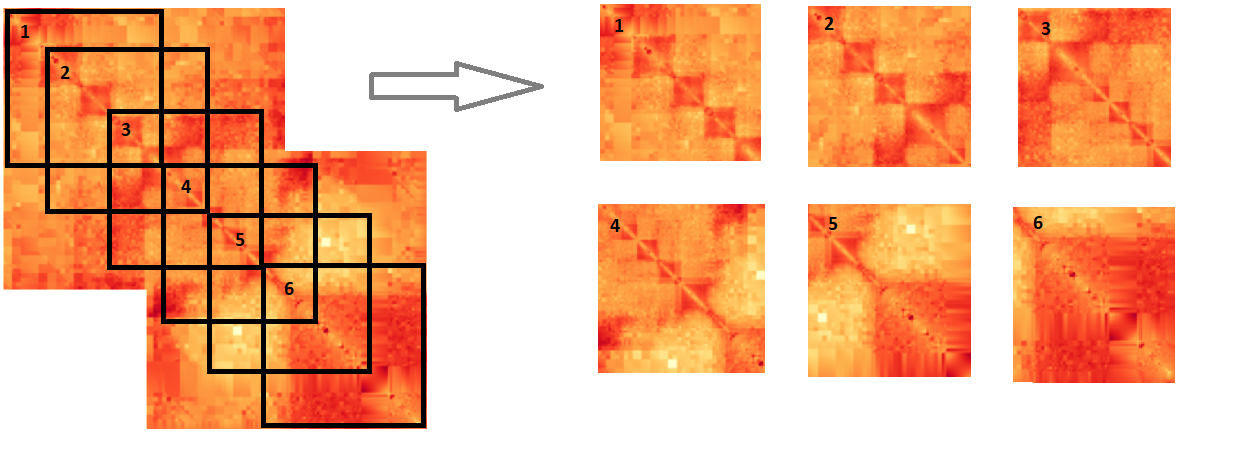

In [ ]:
Model = ModelMaster(data,
        saving_dir = 'saving_dir', 
        model_dir = None, 
        rewrite = True,  
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])
Model.enc = tf.keras.models.load_model(folder+'dm_enc_tpu_2.h5')
Model.dec = tf.keras.models.load_model(folder+'dm_dec_tpu_2.h5')
Model.model = tf.keras.models.load_model(folder + 'dm_model_tpu_2.h5')
Model.encode_y()

In [ ]:
latent_dim = 24
input_len = 2**18
def enc():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(input_shape=(64, 64, 1),
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='linear')])
    return model

def dec():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(input_shape=(latent_dim, ), units=16*16*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same', activation='tanh')])
    return model

def model(input_len=input_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model

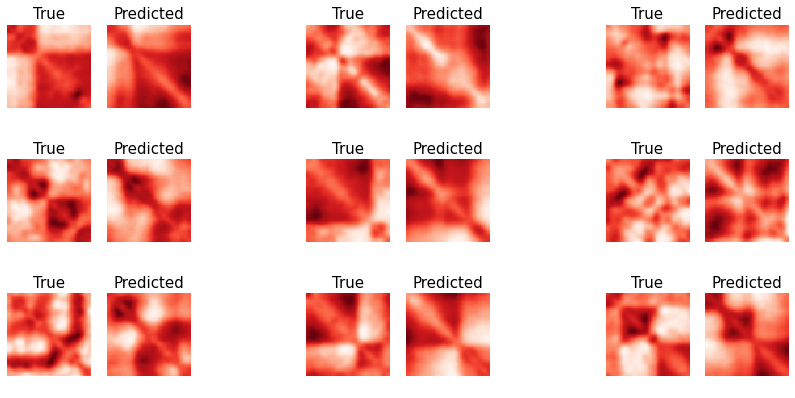

In [ ]:
Model.plot_results(['val', 18])

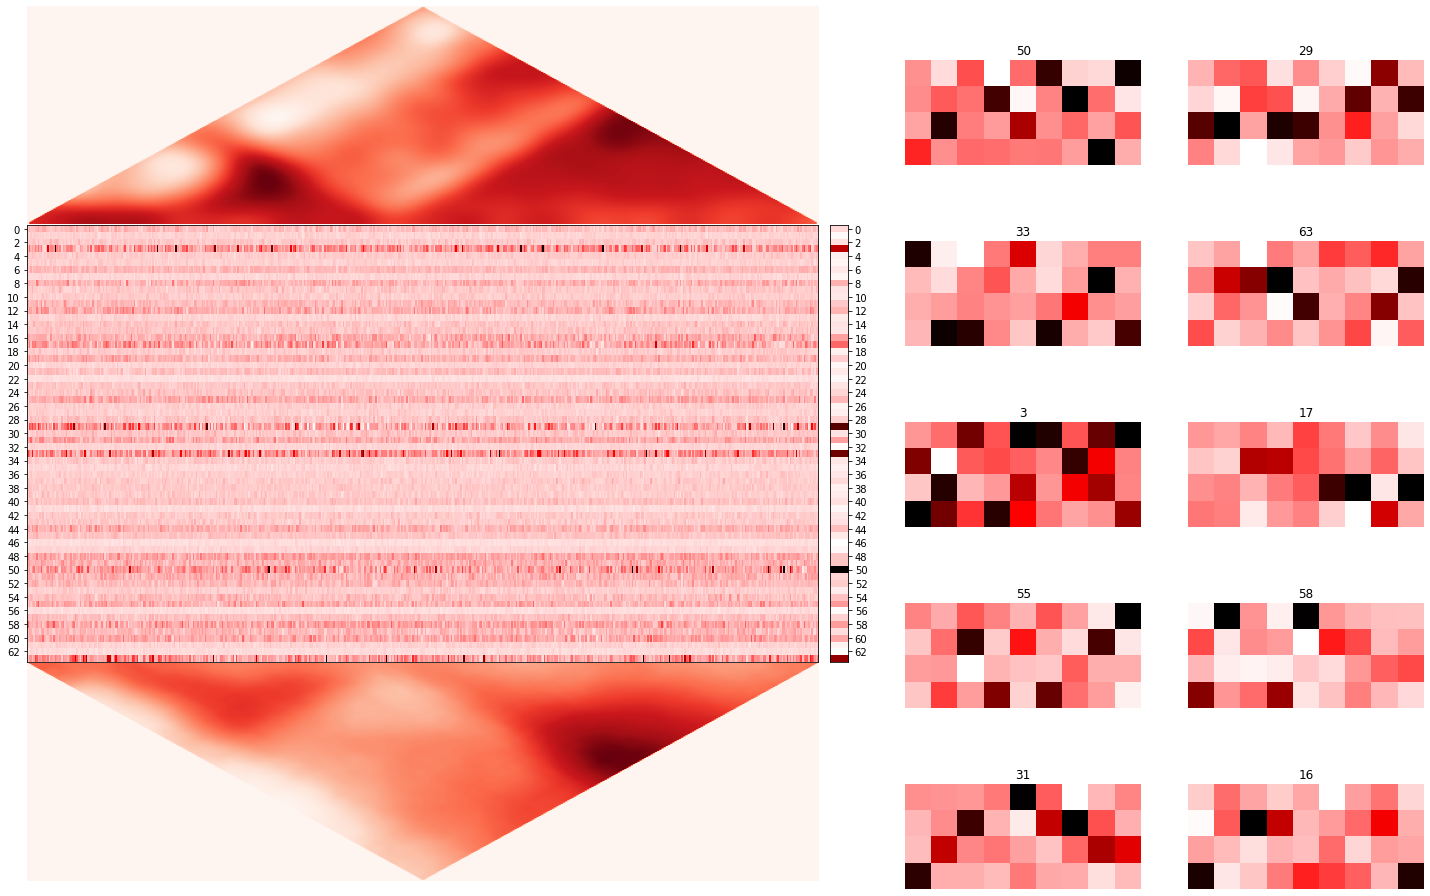

In [ ]:
filters = Model.graphic_analisis(44,
                                theme='light',
                                n_layers=3,
                                color_shifts={'heatmap': 200, 'filters': 200},
                                return_filters=True,
                                aggregation='max')

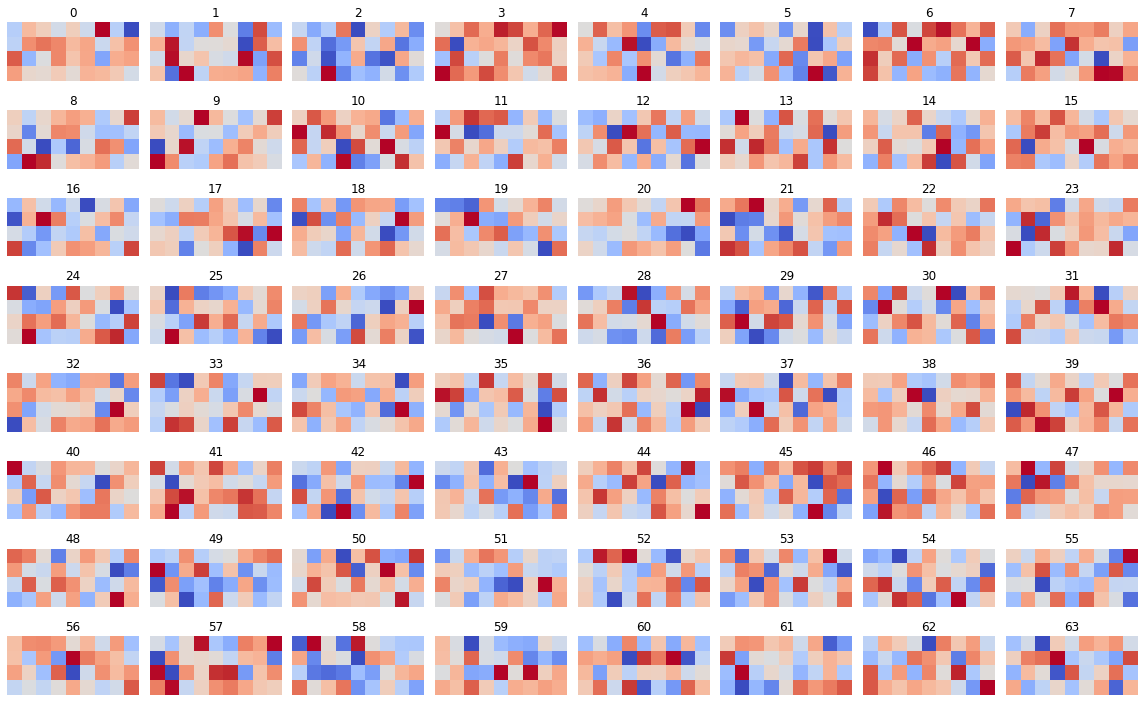

In [ ]:
Model.plot_filters()

In [ ]:
Model.score()

Pearson correlation for training sample (random 128): 0.7633
Pearson correlation for validation sample (whole - 256): 0.4288
Pearson correlations for both samples where X and y are permuted:   0.0054, -0.0910


In [ ]:
def model(input_len=input_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model

Model = ModelMaster(data,
        saving_dir = folder+'Dm_2', 
        model_dir = None, 
        rewrite = True,  
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])
Model.build_enc(enc)
Model.build_dec(dec)
Model.build_model(model)

In [ ]:
Model.train(10000, batch_size=16, callbacks='classical')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 262144, 64)        2368      
_________________________________________________________________
batch_normalization (BatchNo (None, 262144, 64)        256       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 131072, 64)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 131072, 64)        20544     
_________________________________________________________________
dropout (Dropout)            (None, 131072, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 131072, 64)        256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 65536, 64)        

KeyboardInterrupt: ignored

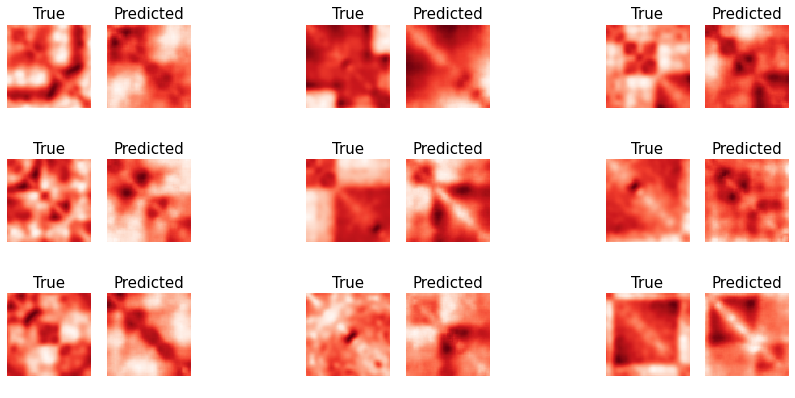

In [ ]:
Model.plot_results()

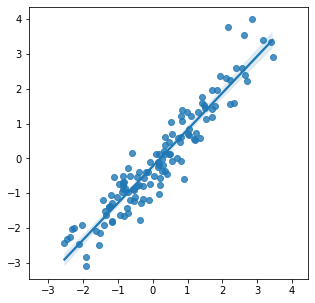

In [ ]:

pca = Model.pca
y = pca(data.y_latent_train[:128])
x = pca(Model.dna_to_latent(data.x_train[:128]))
plt.figure(figsize=(5,5))
sns.regplot(x[0], y[0])
plt.axis('equal')
plt.show()



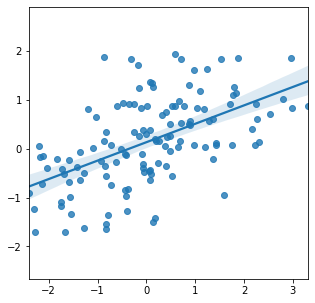

In [ ]:
pca = Model.pca
y = pca(data.y_latent_val)
x = pca(Model.dna_to_latent(data.x_val))
plt.figure(figsize=(5,5))
sns.regplot(y[0], x[0])
plt.axis('equal')
plt.show()

(-2.5733511447906494,
 3.3446505069732666,
 -3.5182601290053626,
 4.351076222966145)

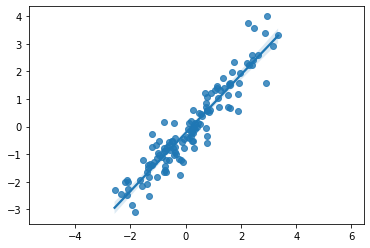

In [ ]:
import seaborn as sns
sns.regplot(x[0], y[0])
plt.axis('equal')

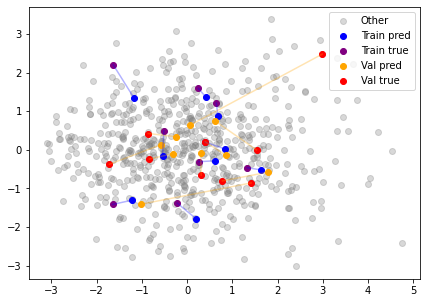

In [ ]:
Model.plot_pca()

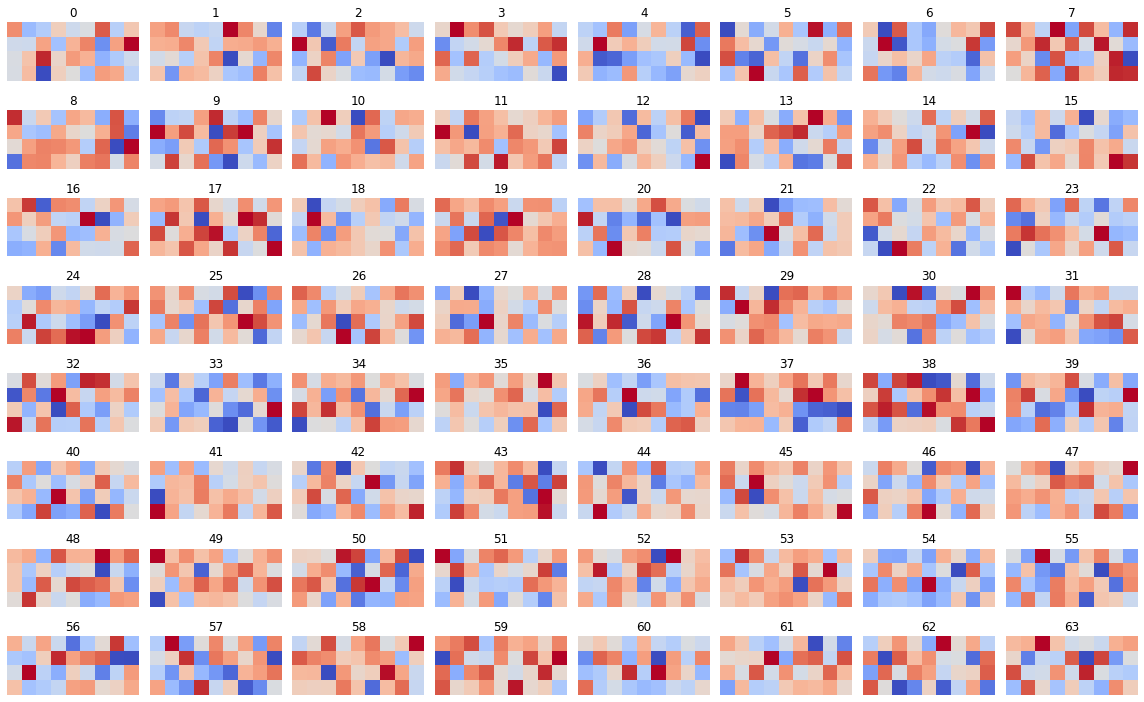

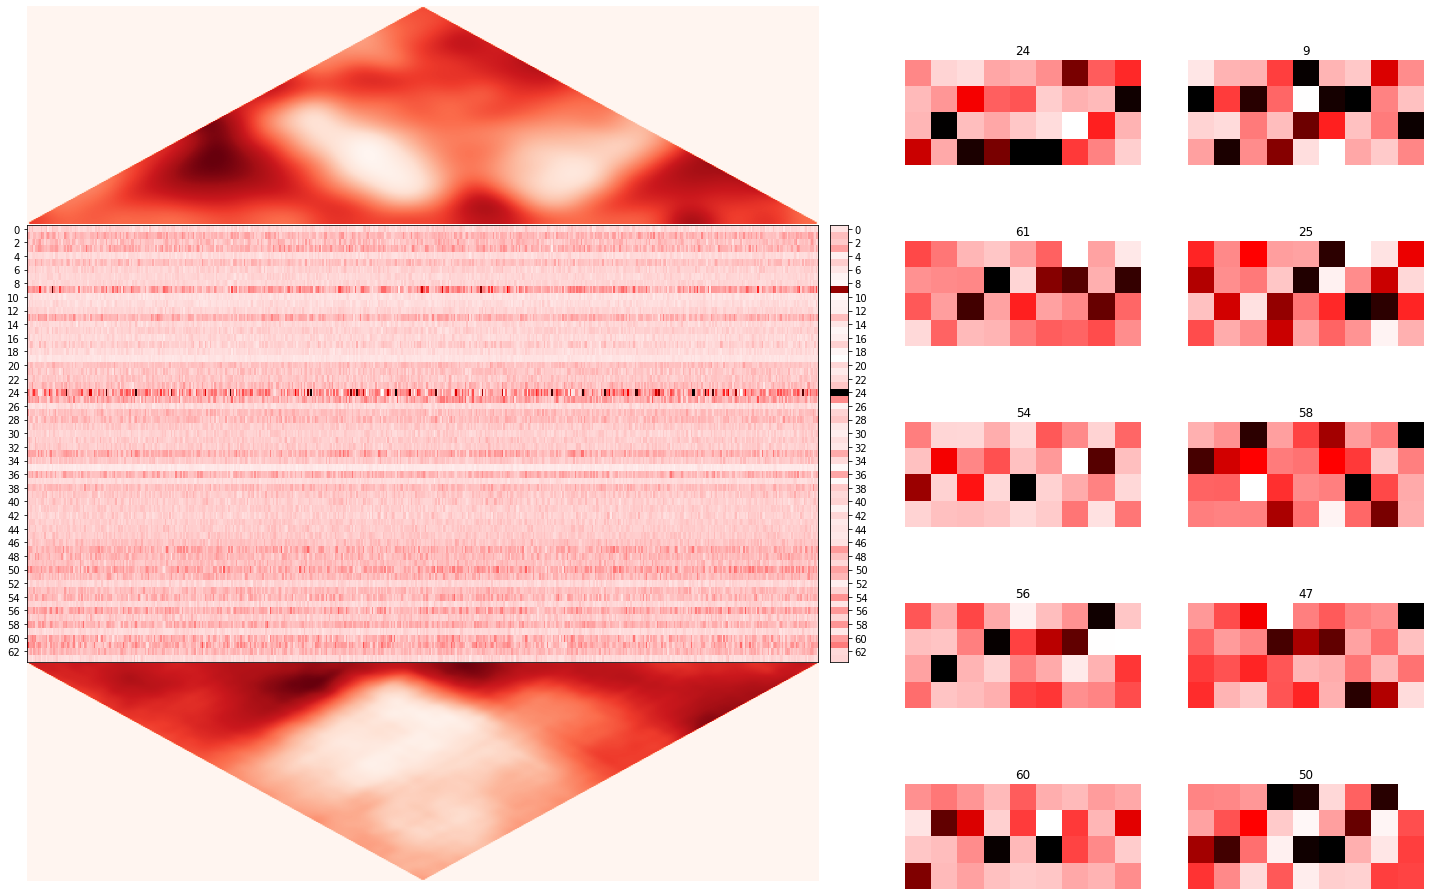

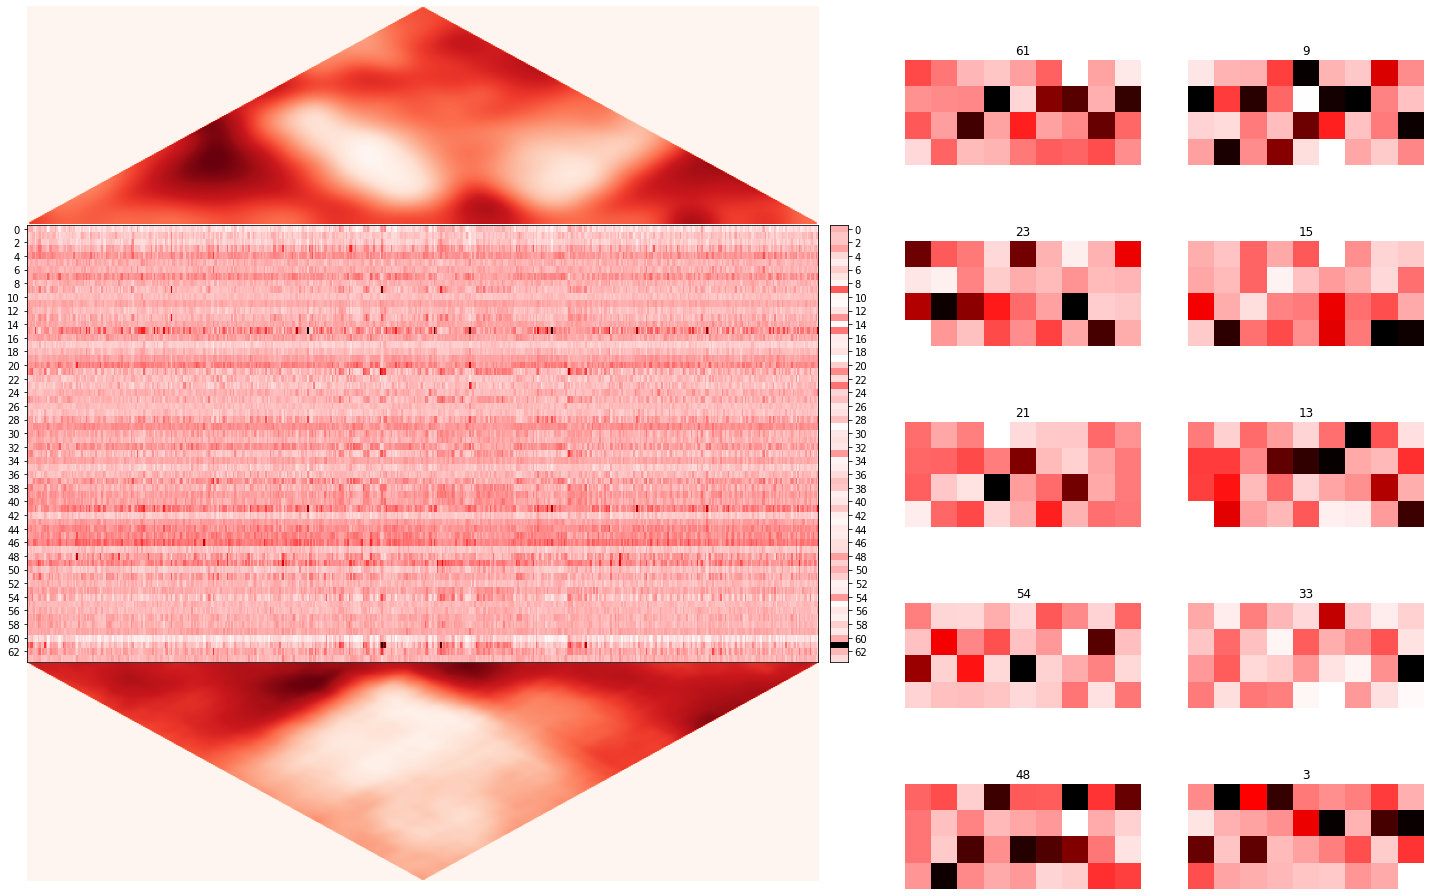

Pearson correlation for training sample (random 128): 0.9124
Pearson correlation for validation sample (whole - 128): 0.5028
Pearson correlations for both samples where X and y are permuted:   0.0553, 0.0051


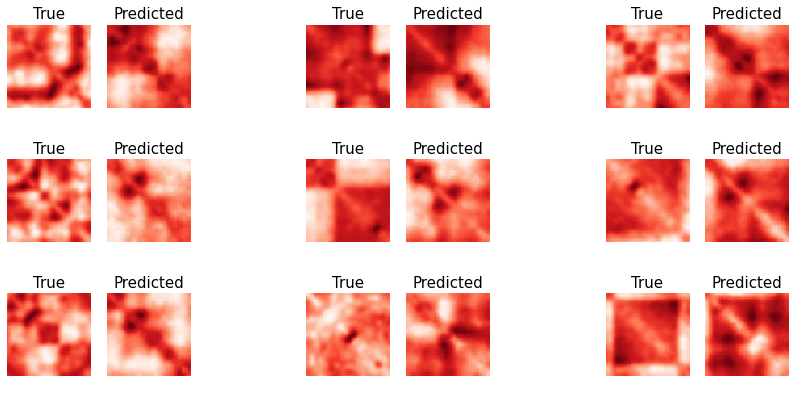

In [ ]:
Model.plot_filters()
Model.graphic_analisis(3, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='max', return_filters=False)
Model.graphic_analisis(3, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='mean', return_filters=False)
Model.predict_as_training = False
Model.score()
Model.plot_results()

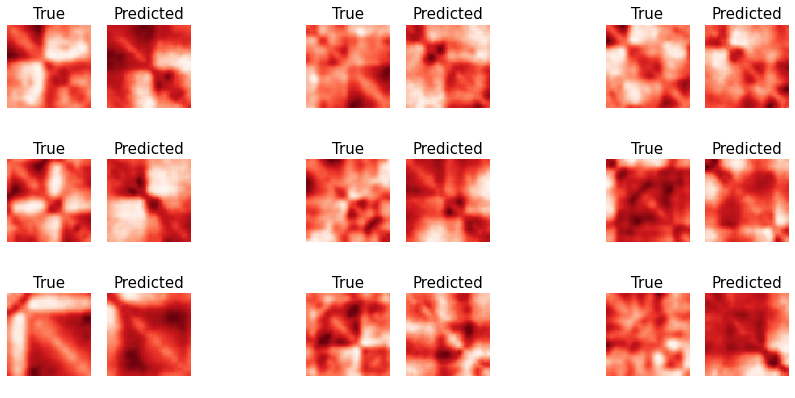

In [ ]:
Model.plot_results(['val', 0])

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Dm_1', 
        model_dir = folder+'Dm_1', 
        rewrite = True,  
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])

Hi-C maps successfully encoded


In [ ]:
Model.predict_as_training = False
Model.score()

Pearson correlation for training sample (random 128): 0.8700
Pearson correlation for validation sample (whole - 128): 0.5369
Pearson correlations for both samples where X and y are permuted:   -0.0464, -0.0276


In [ ]:
Model.predict_as_training = True
Model.score()

Pearson correlation for training sample (random 128): 0.8014
Pearson correlation for validation sample (whole - 128): 0.4371
Pearson correlations for both samples where X and y are permuted:   0.0599, 0.0025


In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Dm_3', 
        model_dir = folder+'Dm_1', 
        rewrite = True, 
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])

Hi-C maps successfully encoded


In [ ]:
latent_dim = 24
input_len = 2**18
def model(input_len=input_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'))
    model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        model.add(tf.keras.layers.Dropout(0.15))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model

Model.build_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 262144, 64)        2368      
_________________________________________________________________
dropout_12 (Dropout)         (None, 262144, 64)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 262144, 64)        256       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 131072, 64)        0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 131072, 64)        20544     
_________________________________________________________________
dropout_13 (Dropout)         (None, 131072, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 131072, 64)       

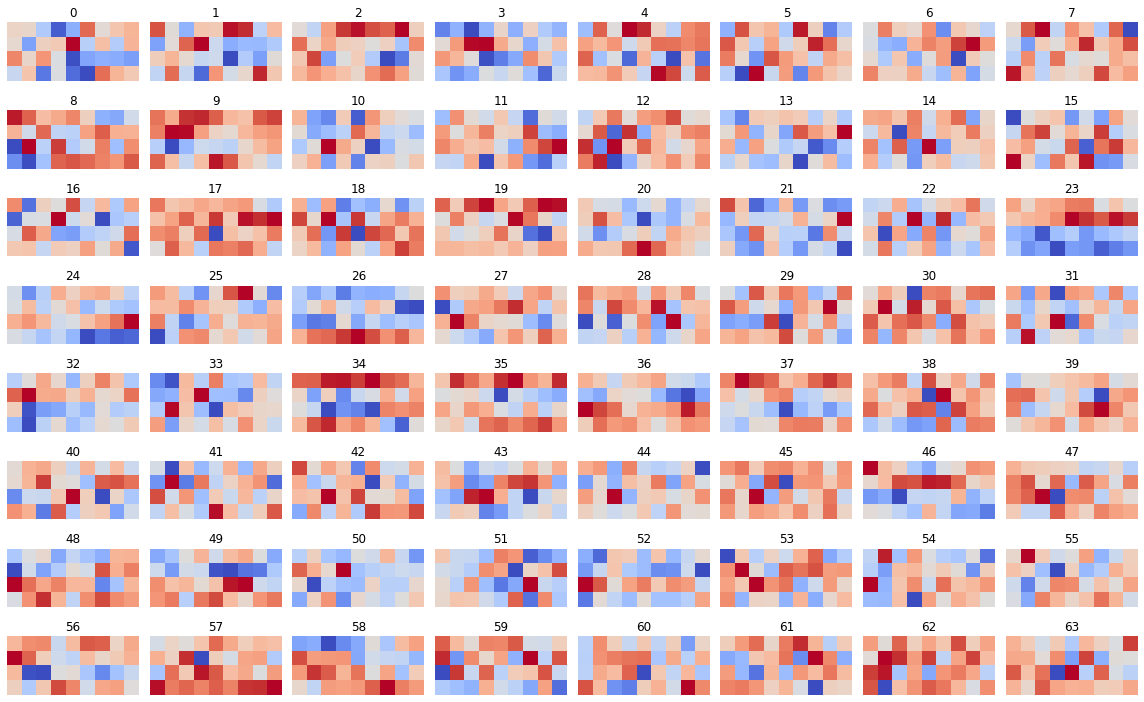

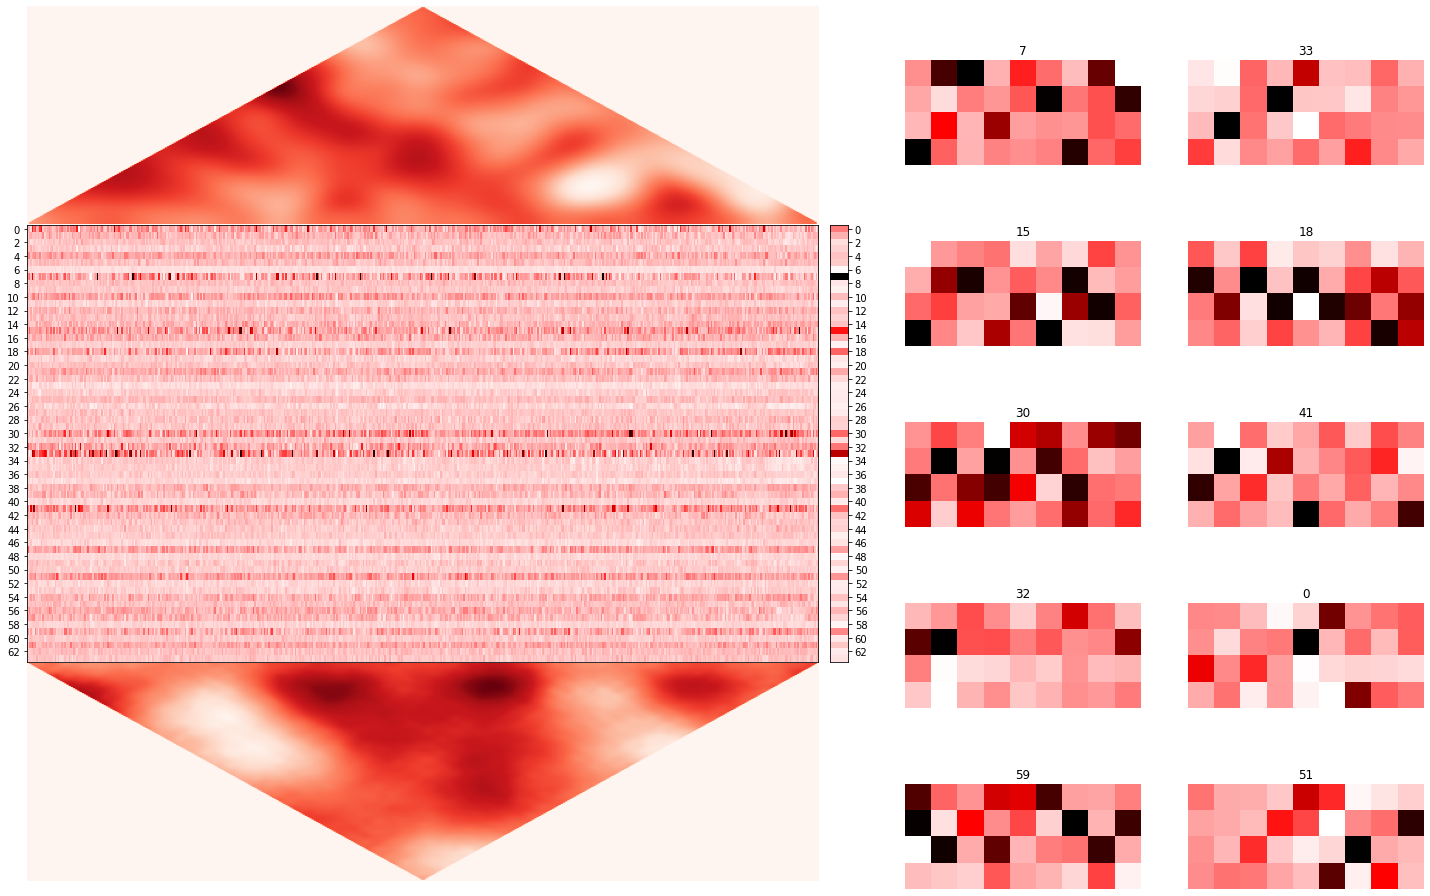

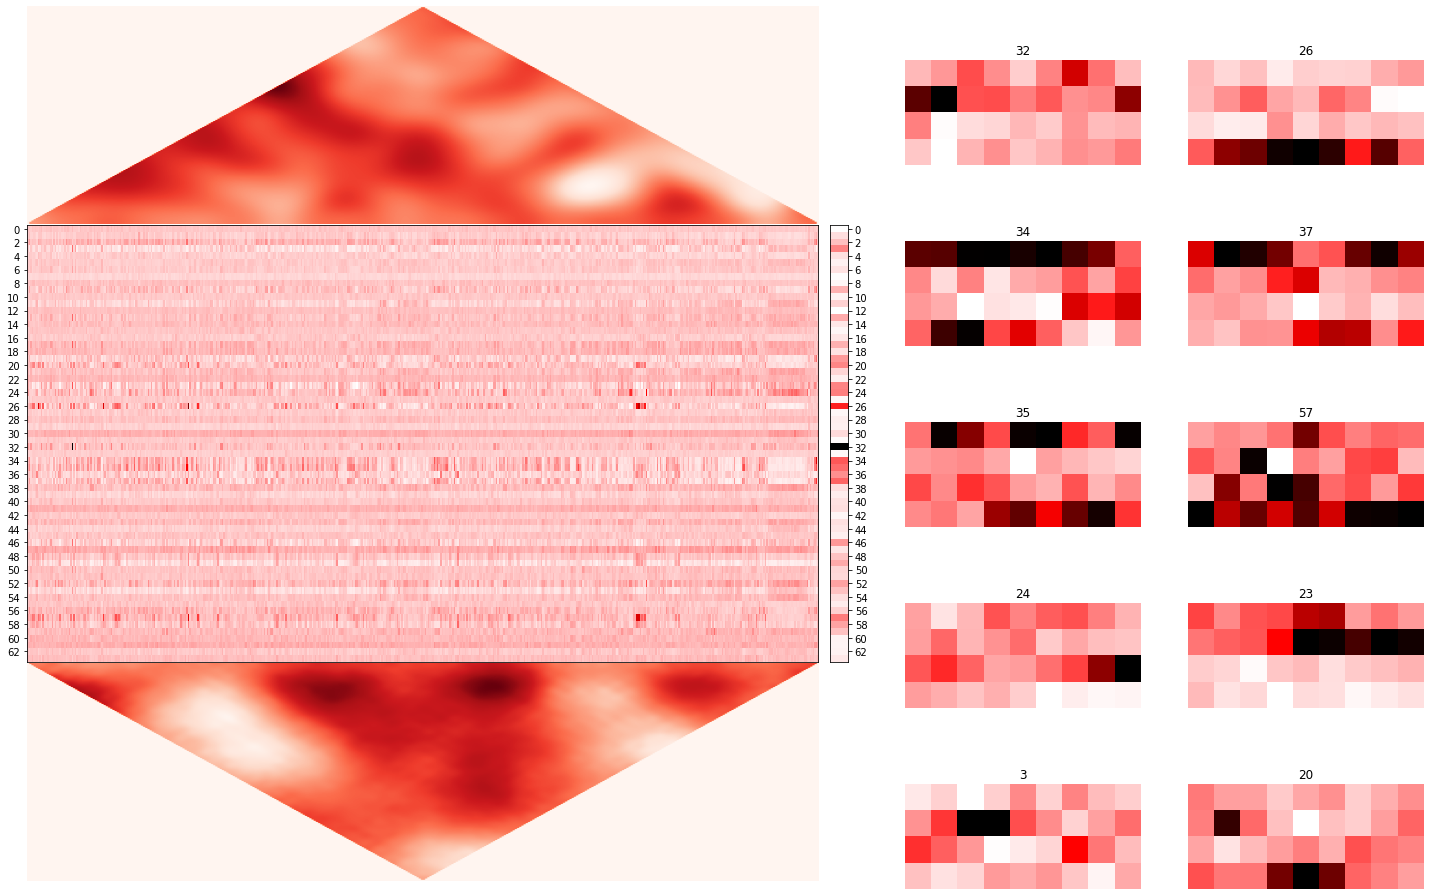

Pearson correlation for training sample (random 128): 0.6987
Pearson correlation for validation sample (whole - 128): 0.4365
Pearson correlations for both samples where X and y are permuted:   -0.0352, 0.0548


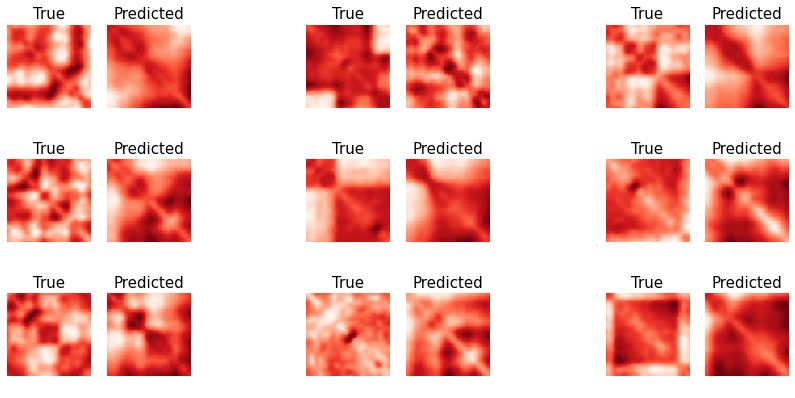

Hi-C maps successfully encoded
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 262144, 64)        2368      
_________________________________________________________________
batch_normalization_24 (Batc (None, 262144, 64)        256       
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 131072, 64)        0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 131072, 64)        20544     
_________________________________________________________________
batch_normalization_25 (Batc (None, 131072, 64)        256       
_________________________________________________________________
max_pooling1d_23 (MaxPooling (None, 65536, 64)         0         
_________________________________________________________________
conv1d_24 (Conv1D)     

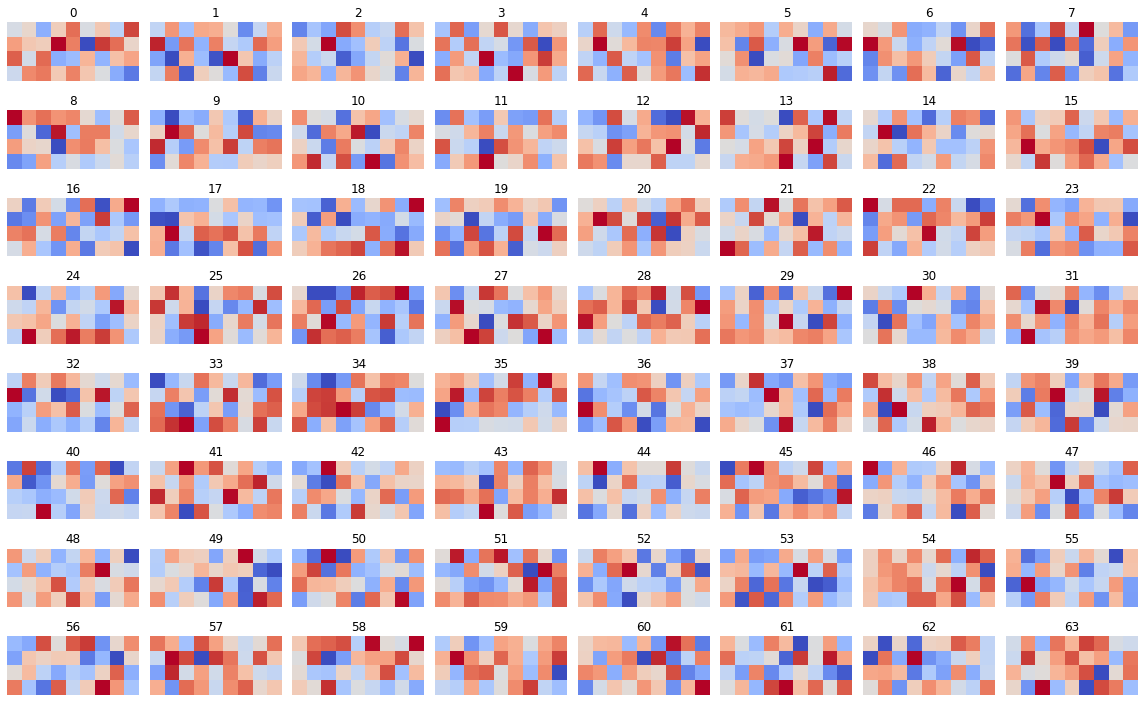

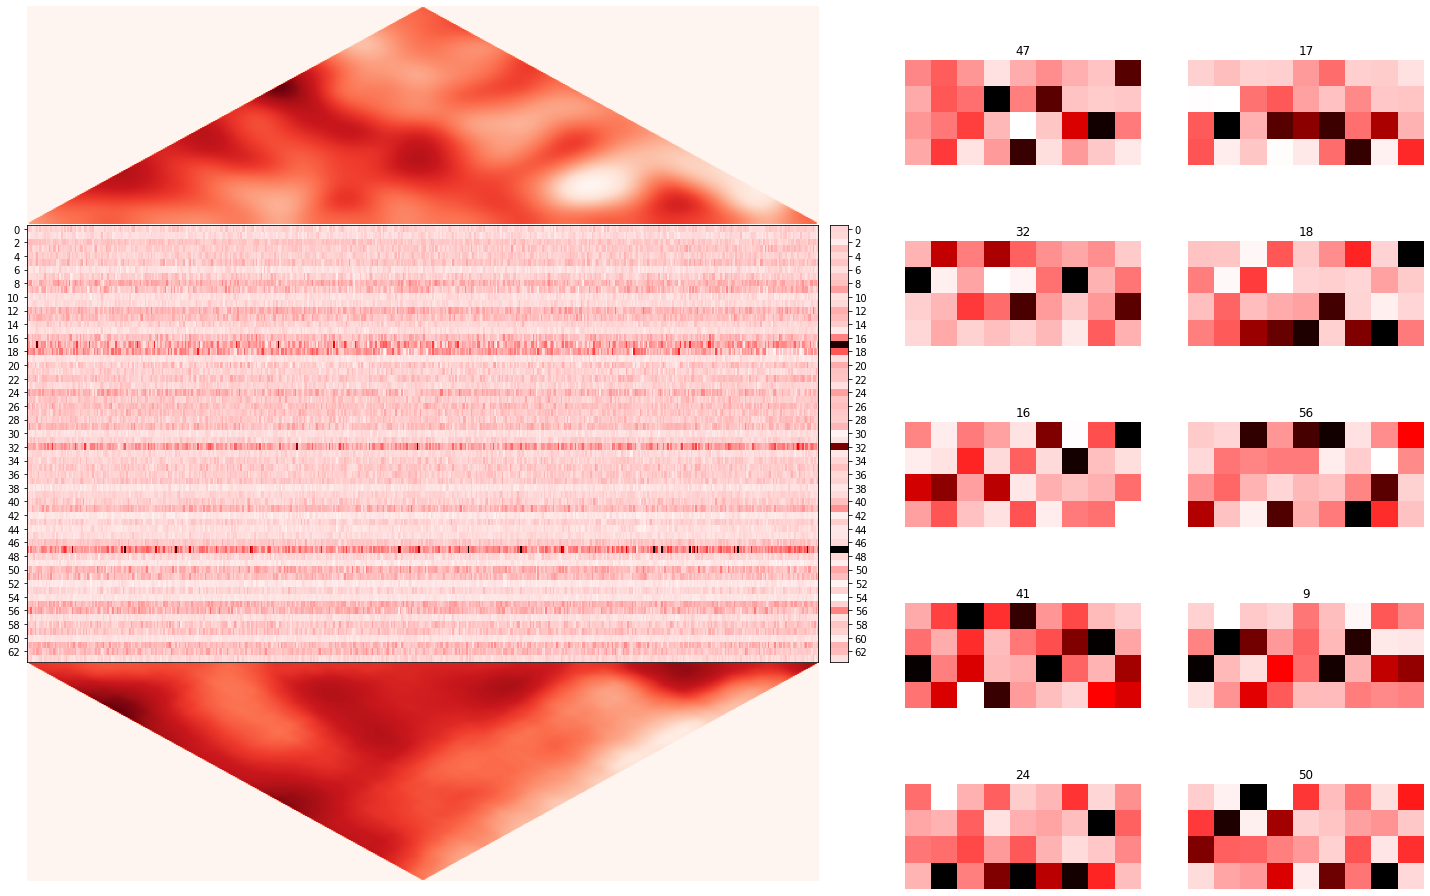

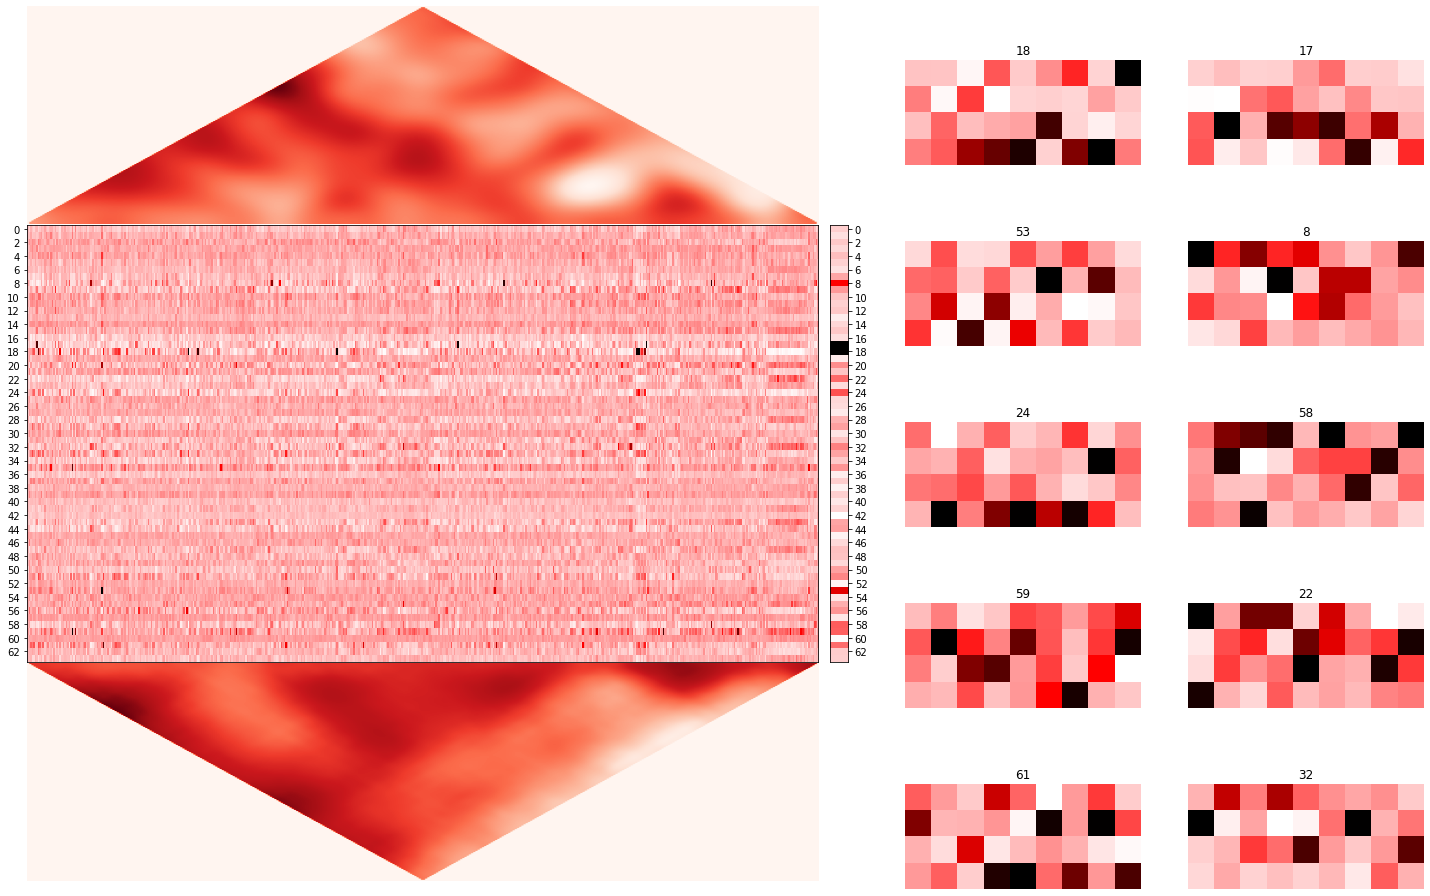

Pearson correlation for training sample (random 128): 0.9598
Pearson correlation for validation sample (whole - 128): 0.4898
Pearson correlations for both samples where X and y are permuted:   0.0004, 0.0844


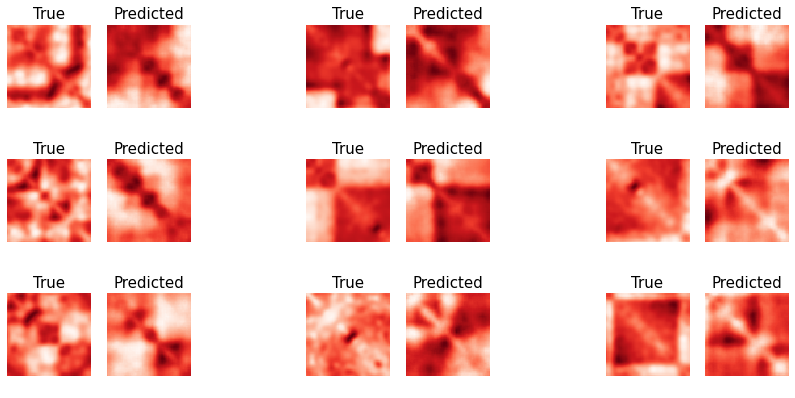

In [ ]:
Model.train(140, batch_size=16, callbacks='classical')
Model.plot_filters()
Model.graphic_analisis(8, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='max', return_filters=False)
Model.graphic_analisis(8, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='mean', return_filters=False)
Model.predict_as_training = False
Model.score()
Model.plot_results()


latent_dim = 24
input_len = 2**18
def model(input_len=input_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'))
    #model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', dilation_rate = 2, activation='relu'))
        #model.add(tf.keras.layers.Dropout(0.15))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model


Model = ModelMaster(data,
        saving_dir = folder+'Dm_4', 
        model_dir = folder+'Dm_1', 
        rewrite = True, 
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])
Model.build_model(model)
Model.train(140, batch_size=16, callbacks='classical')
Model.plot_filters()
Model.graphic_analisis(8, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='max', return_filters=False)
Model.graphic_analisis(8, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='mean', return_filters=False)
Model.predict_as_training = False
Model.score()
Model.plot_results()



In [ ]:
Model.predict_as_training = True
Model.score()

Pearson correlation for training sample (random 128): 0.8263
Pearson correlation for validation sample (whole - 128): 0.3889
Pearson correlations for both samples where X and y are permuted:   0.0501, -0.0515


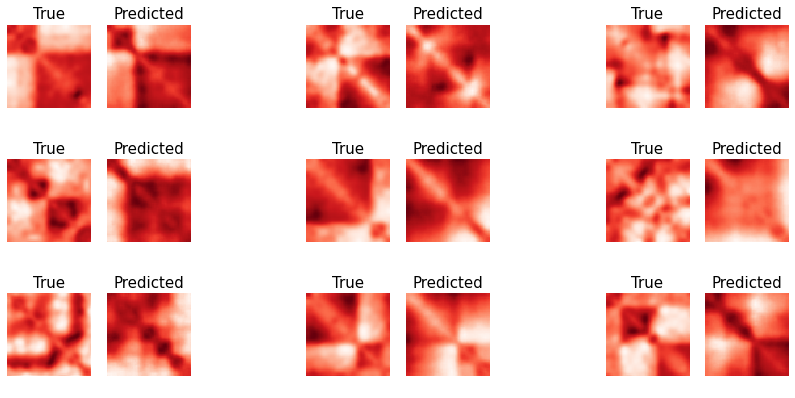

In [ ]:
Model.predict_as_training = False
Model.plot_results(['val', 18])

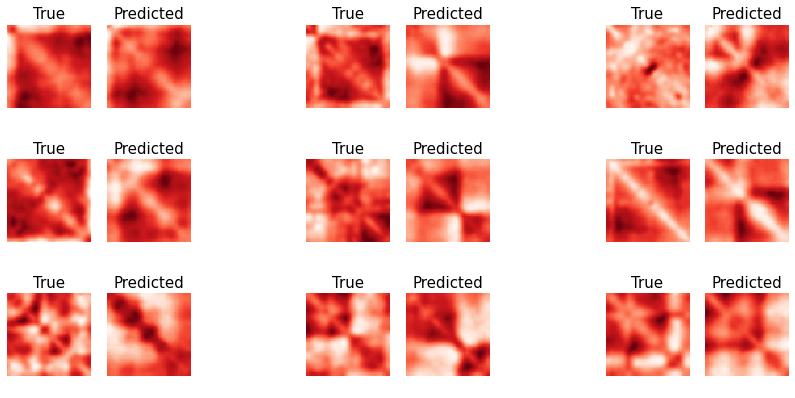

In [ ]:
Model.predict_as_training = False
Model.plot_results(['val', 99])

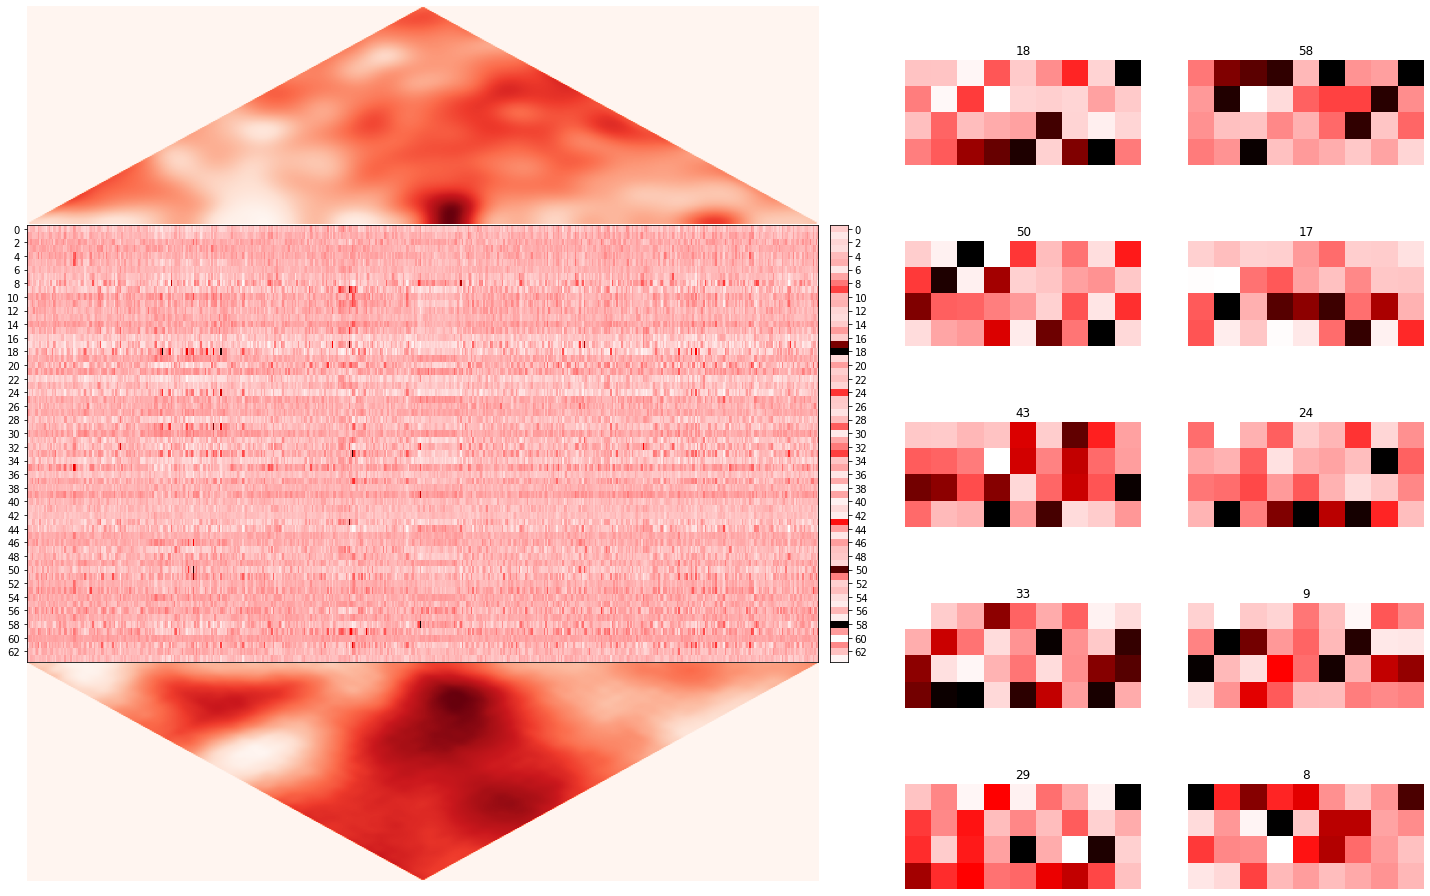

In [ ]:
Model.graphic_analisis(92, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='mean', return_filters=False)

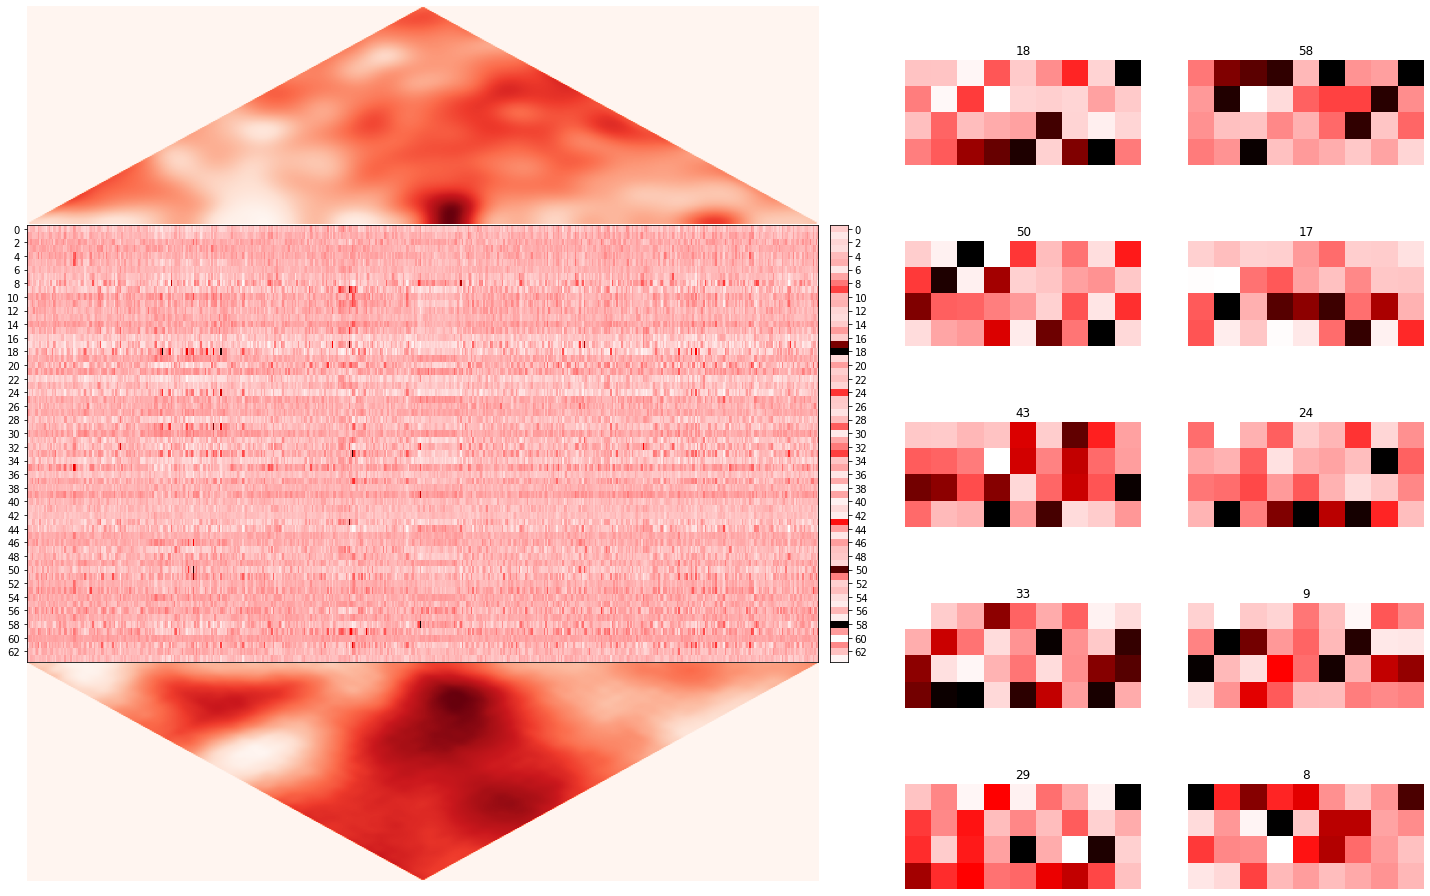

In [ ]:
Model.graphic_analisis(92, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='mean', return_filters=False)

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Dm_4', 
        model_dir = folder+'Dm_4', 
        rewrite = True, 
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])


In [ ]:
Model.load_test_chromosome('chr4', cut_chromosome_ends=0)

DNA data for chr4 is loaded

Maps are zoomed 0.9846153846153847 times
For 64x64 map used 65536 + 131072 + 65536 nucleotide fragments
Initial dataset contains 262144x262144 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr4 is loaded


4/4 [==============================] - 2s 442ms/step


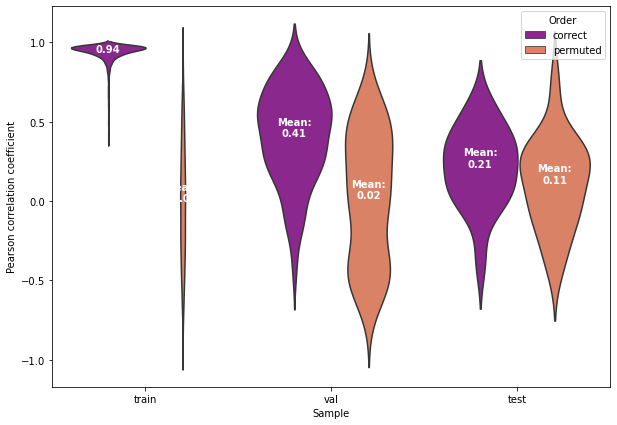

In [ ]:
Model.score()

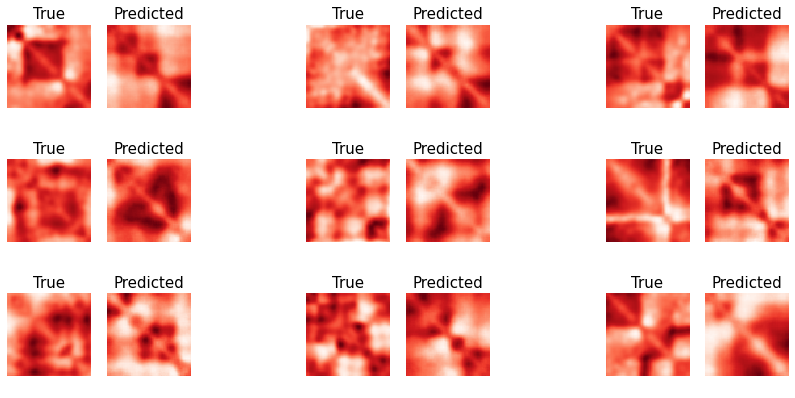

In [ ]:
Model.plot_results(['test', 0])

In [ ]:
Переделать отрисовку теста, убрав выборку
Обучить дрозофилу без икс хромосомы

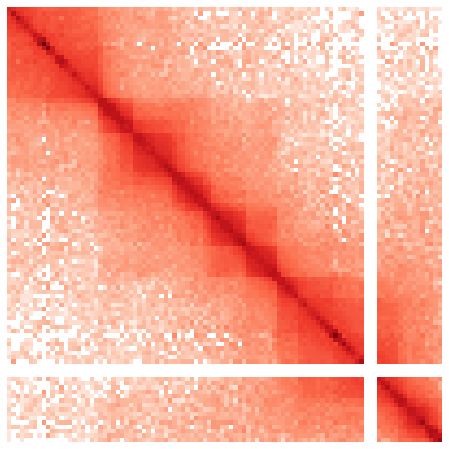

(-0.5, 99.5, 99.5, -0.5)

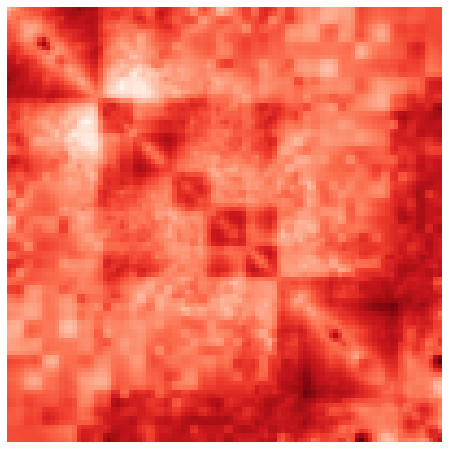

In [ ]:
bal=data.cooler.matrix(balance=True)
raw=data.cooler.matrix(balance=True)
from cooltools.lib.numutils import interp_nan, observed_over_expected, adaptive_coarsegrain
b, a = bal.fetch('chr3R:100000-1200000'), raw.fetch('chr3R:1000000-1200000')
plt.figure(figsize=(8,8))
plt.imshow(np.log(a), interpolation='none', cmap='Reds')

plt.axis('off')
plt.show()
plt.figure(figsize=(8,8))
from scipy.ndimage import rotate, zoom, gaussian_filter

plt.imshow(gaussian_filter(data.get_region('chr3R', 1000000, 1200000)[0],0.7), interpolation='none', cmap='Reds')
plt.axis('off')

In [ ]:
data = DataMaster(
                hic_file = hic_name, 
                genome_file_or_dir = genome, 
                fragment_length = 2**17,
                sigma = 2,
                chroms_to_exclude = ['chr4', 'chrX'],
                scale = (0, 1),
                map_size = 64,
                nan_threshold = 0.15,
                stochastic_sampling = False,
                rev_comp=True,
                shift_repeats = 8,
                expand_dna = True,
                val_split = ('last', 64),
                cut_chromosome_ends = 2**19,
                sample_seed = 0)

DNA data for chr2L is loaded
DNA data for chr2R is loaded
DNA data for chr3L is loaded
DNA data for chr3R is loaded
DNA data for chrM is loaded

Maps are zoomed 0.9846153846153847 times
For 64x64 map used 65536 + 131072 + 65536 nucleotide fragments
Initial dataset contains 262144x262144 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr2L is loaded
Hi-C data for chr2R is loaded
Hi-C data for chr3L is loaded
Hi-C data for chr3R is loaded
Hi-C data for chrM is loaded


In [ ]:
latent_dim = 24
input_len = 2**18
def enc():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(input_shape=(64, 64, 1),
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='linear')])
    return model

def dec():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(input_shape=(latent_dim, ), units=16*16*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')])
    return model

def model(input_len=input_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 9, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model



Model = ModelMaster(data,
        saving_dir = folder+'Dm_5', 
        model_dir = folder+'Dm_5',
        rewrite = True, 
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])
Model.build_enc(enc)
Model.build_dec(dec)
Model.build_model(model)

In [ ]:
Model.train(1000, batch_size=16, callbacks='classical')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 262144, 64)        2368      
_________________________________________________________________
batch_normalization_12 (Batc (None, 262144, 64)        256       
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 131072, 64)        0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 131072, 64)        20544     
_________________________________________________________________
dropout (Dropout)            (None, 131072, 64)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 131072, 64)        256       
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 65536, 64)        

KeyboardInterrupt: ignored

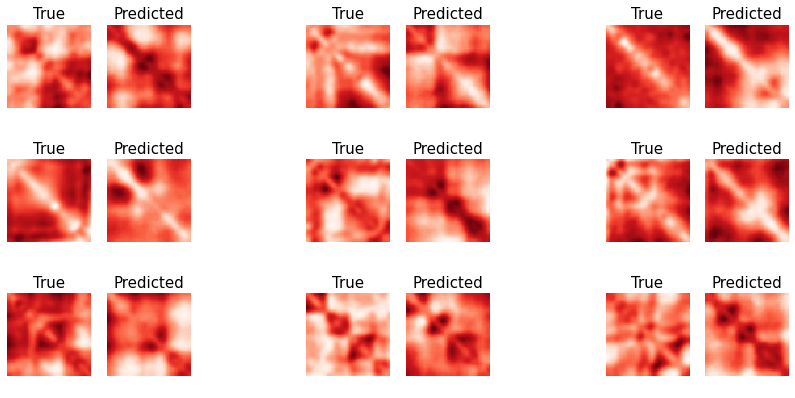

In [ ]:
Model.plot_results()

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Dm_5', 
        model_dir = folder+'Dm_5',
        rewrite = True, 
        framework = 'tensorflow', 
        model_parts = ['enc', 'dec', 'model'])

Hi-C maps successfully encoded


DNA data for chrX is loaded

Maps are zoomed 0.9846153846153847 times
For 64x64 map used 65536 + 131072 + 65536 nucleotide fragments
Initial dataset contains 262144x262144 maps, overlooping in 64 pixels
128x128 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chrX is loaded


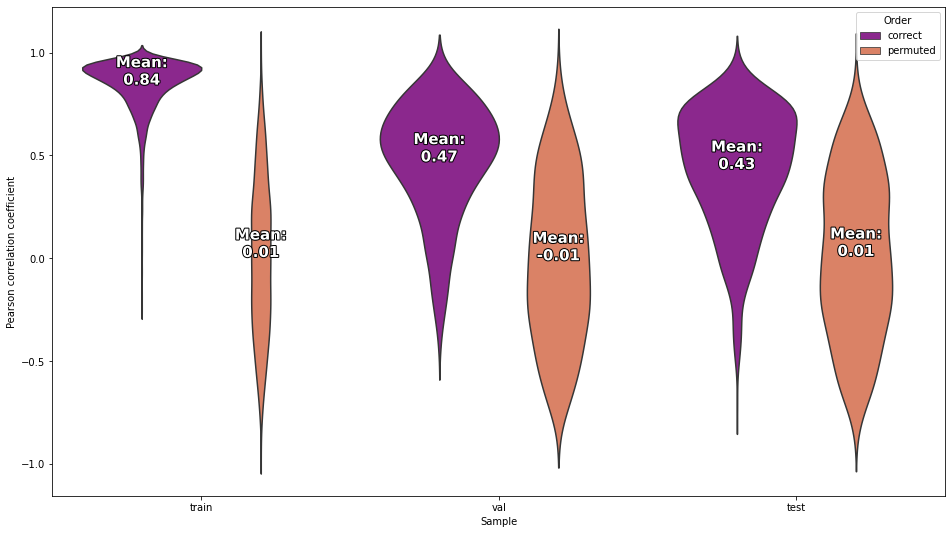

In [ ]:
Model.predict_as_training = True
Model.load_test_chromosome('chrX')
Model.score(prediction='train')

In [ ]:
import importlib
import hicpredictor.training as training
importlib.reload(training)
ModelMaster = training.ModelMaster

In [ ]:
Model = ModelMaster(model_dir = folder + 'Dm_5', 
        saving_dir = folder + 'Dm_7', 
        rewrite = True)

DNA data for chr2L is loaded
DNA data for chr2R is loaded
DNA data for chr3L is loaded
DNA data for chr3R is loaded
DNA data for chrM is loaded

Maps are zoomed 0.9846153846153847 times
For 64x64 map used 65536 + 131072 + 65536 nucleotide fragments
Initial dataset contains 128x128 maps, overlooping in 64 pixels
64x64 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr2L is loaded
Hi-C data for chr2R is loaded
Hi-C data for chr3L is loaded
Hi-C data for chr3R is loaded
Hi-C data for chrM is loaded
Hi-C maps successfully encoded


In [ ]:
Model.train(epochs = 1000, batch_size=16, callbacks = 'classical')

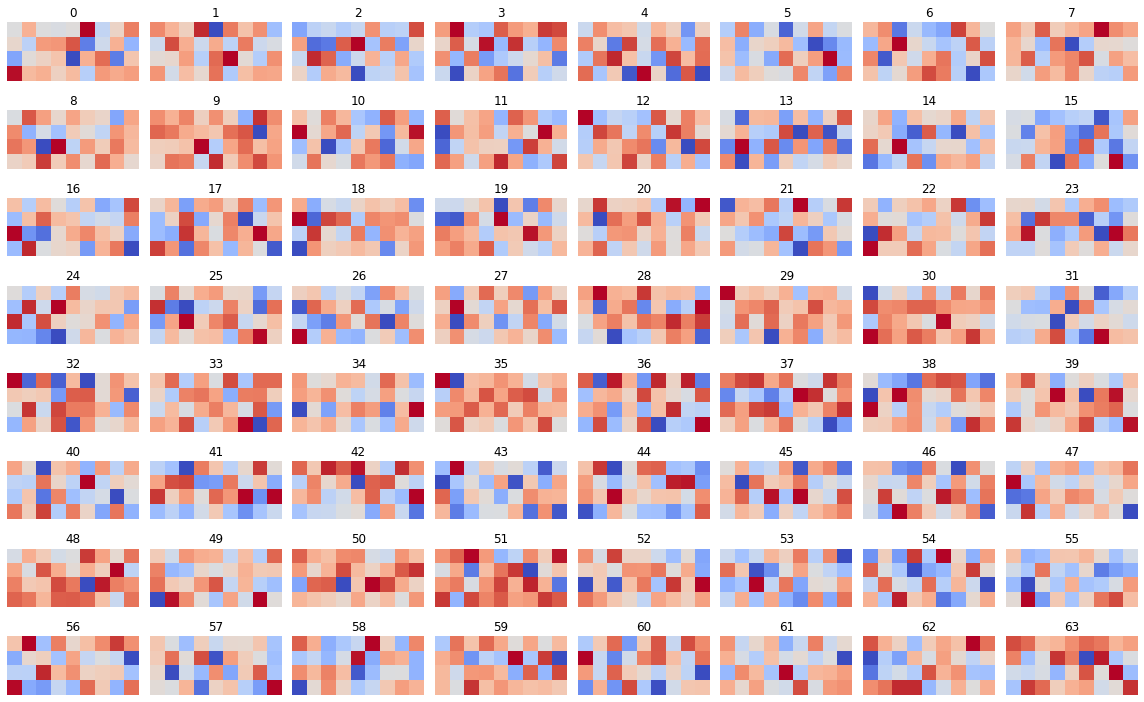

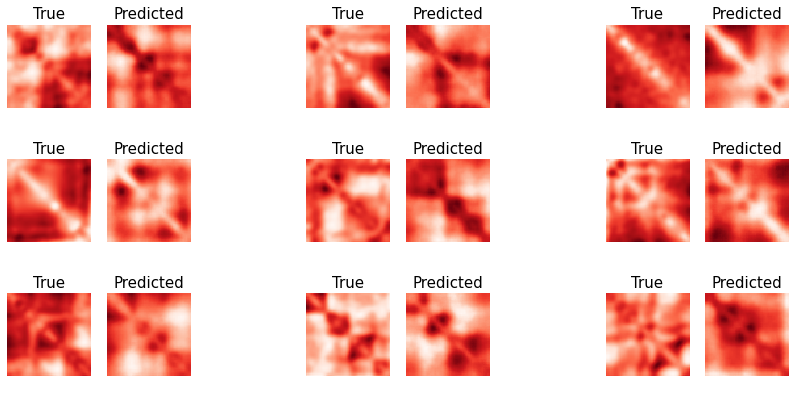

32/32 [==============================] - 23s 723ms/step


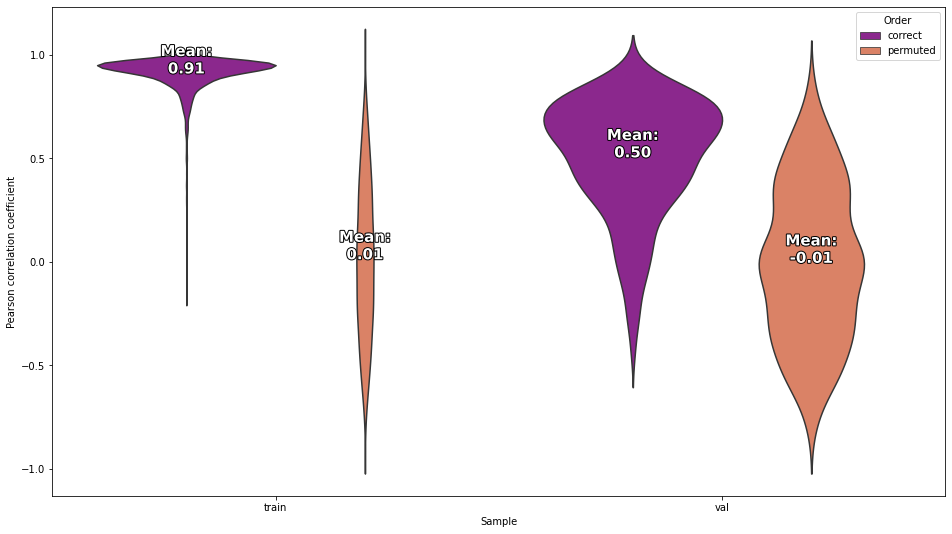

In [ ]:
Model.plot_filters()
Model.plot_results()
Model.score()

In [ ]:
Model.graphic_analisis()

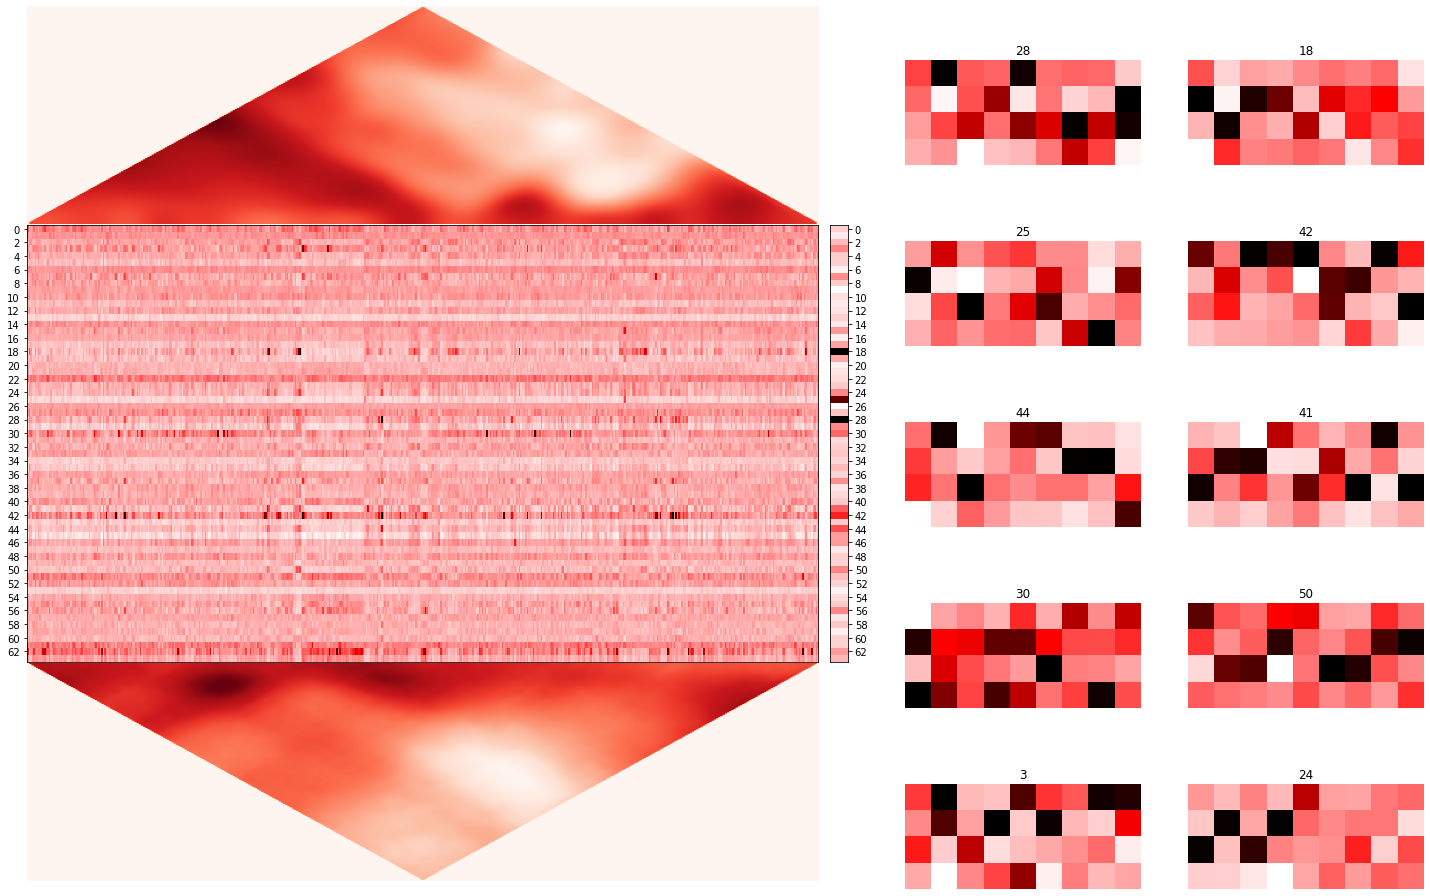

In [ ]:
Model.graphic_analisis(92, n_layers=3, theme='light', color_shifts={'heatmap': 200, 'filters': 200}, aggregation='mean', return_filters=False)

In [ ]:
sys.path.insert(0, folder)
from hicpredictor.dataset import DataMaster
from hicpredictor.training import ModelMaster
from hicpredictor.plot import *

In [ ]:
import importlib
import hicpredictor.training as training
importlib.reload(training)
ModelMaster = training.ModelMaster

import importlib
import hicpredictor.dataset as dataset
importlib.reload(dataset)
DataMaster = dataset.DataMaster

In [ ]:
data = DataMaster(
                hic_file = hic_name, 
                genome_file_or_dir = genome, 
                fragment_length = 2**17,
                sigma = 2,
                chroms_to_exclude = ['chr4', 'chrX'],
                scale = (0, 1),
                normalize = 'each',
                map_size = 64,
                nan_threshold = 0.15,
                stochastic_sampling = False,
                rev_comp = False,
                shift_repeats = 8,
                expand_dna = True,
                val_split = ('last', 64),
                cut_chromosome_ends = 2**19,
                sample_seed = 0)

DNA data for chr2L is loaded
DNA data for chr2R is loaded
DNA data for chr3L is loaded
DNA data for chr3R is loaded
DNA data for chrM is loaded

Maps are zoomed 0.9846153846153847 times
For 64x64 map used 65536 + 131072 + 65536 nucleotide fragments
Initial dataset contains 128x128 maps, overlooping in 64 pixels
64x64 maps for training will be sampled from them, maps for testing are their top left fragments
Hi-C data for chr2L is loaded
Hi-C data for chr2R is loaded
Hi-C data for chr3L is loaded
Hi-C data for chr3R is loaded
Hi-C data for chrM is loaded


In [ ]:
latent_dim = 24
input_len = 2**18
def enc():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Conv2D(input_shape=(64, 64, 1),
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim, activation='linear')])
    return model

def dec():
    model = tf.keras.models.Sequential([
            tf.keras.layers.Dense(input_shape=(latent_dim, ), units=16*16*32, activation='relu'),
            tf.keras.layers.Reshape(target_shape=(16, 16, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')])
    return model

def model(input_len=input_len):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(input_len, 4)))

    model.add(tf.keras.layers.Conv1D(64, 11, padding='same', activation='relu'))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

    pooling_range = int(np.log2(input_len)) - 8
    for block in range(pooling_range):
        model.add(tf.keras.layers.Conv1D(64, 5, padding='same', activation='relu'))
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dropout(0.15))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dense(latent_dim))

    model.compile(loss = 'mse', optimizer = 'nadam')

    return model

In [ ]:
Model = ModelMaster(data,
        saving_dir = folder+'Dm_8',
        rewrite=True)
Model.build(enc, dec, model)
Model.train(1000, callbacks='classical')

In [ ]:
Model.train(1000, callbacks='classical')

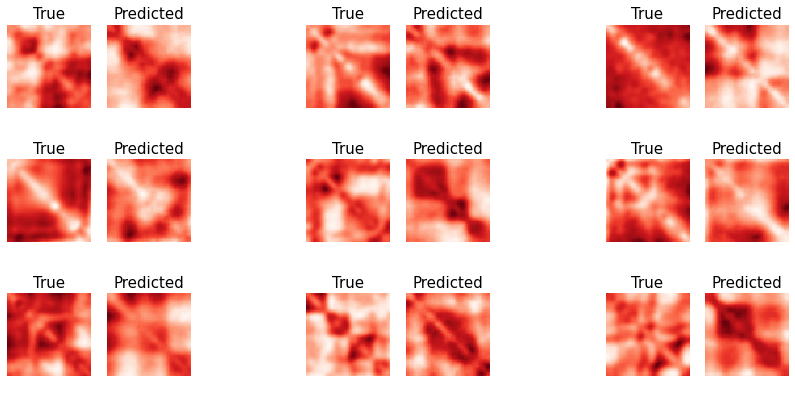

In [ ]:
Model.plot_results()

64/64 [==============================] - 24s 370ms/step


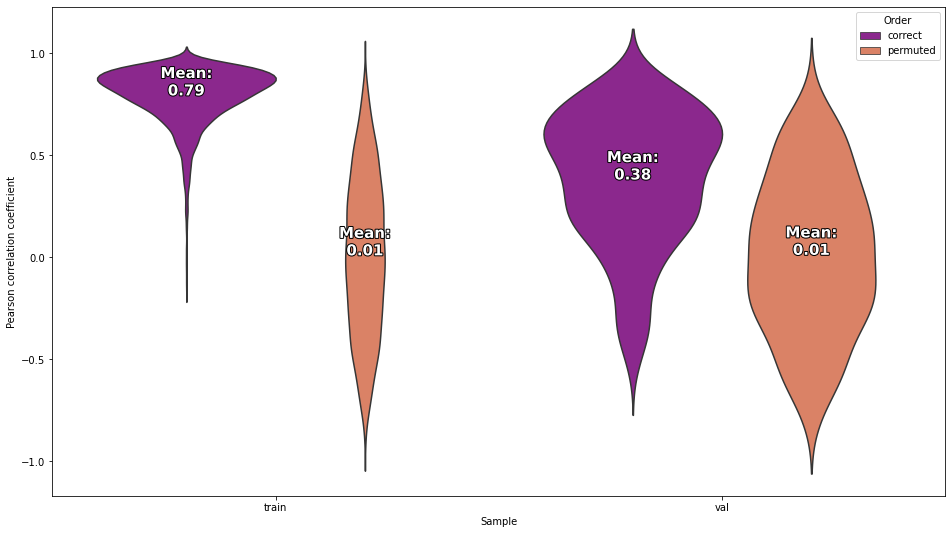

In [ ]:
Model.score()